<a href="https://colab.research.google.com/github/AK18k/auto_map/blob/main/AUTOMAP_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

common code

---



In [1]:
!git clone https://github.com/AK18k/auto_map

Cloning into 'auto_map'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 180 (delta 1), reused 0 (delta 0), pack-reused 174
Receiving objects: 100% (180/180), 15.53 MiB | 22.24 MiB/s, done.
Resolving deltas: 100% (96/96), done.


In [1]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import os
import random
import tensorflow as tf
from tensorflow.python.framework import ops
import cv2
import math
import time
from scipy.io import loadmat
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape
from tensorflow.keras import Model
import glob
from torchvision.transforms import functional as F
from torchvision.transforms import RandomCrop
import torch.nn as nn
import torch.optim as optim
import gc

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

# Define the directory path
directory = '/content/drive/MyDrive/automap/imgs'

# Get a list of all files in the directory
file_list = os.listdir(directory)

print(f'raw img count = {len(file_list)}')

# Select 10 random files from the list
selected_files = file_list[0:200]

# Create a list of full paths for the selected files
file_paths = [os.path.join(directory, filename) for filename in selected_files]

print(file_paths)

# # Print the filenames and their full paths
# for filename, path in zip(random_files, file_paths):
#     print(f"Filename: {filename}")
#     print(f"Full Path: {path}")
#     print()


raw img count = 137
['/content/drive/MyDrive/automap/imgs/10155709300728342918543955138521808206_f7cj92.png', '/content/drive/MyDrive/automap/imgs/10383960670432673238945376919735423432_hd3moq.png', '/content/drive/MyDrive/automap/imgs/1256842362861431725328351539259305635_u1qifz.png', '/content/drive/MyDrive/automap/imgs/10287653421930576798556842610982533460_vpbhw6.png', '/content/drive/MyDrive/automap/imgs/17517381147706809156163698942582418325_tutfbr.png', '/content/drive/MyDrive/automap/imgs/23519598294167460669966745319398153772_4fvhwr.png', '/content/drive/MyDrive/automap/imgs/17871983995291973291210205507121602296_hd8ger.png', '/content/drive/MyDrive/automap/imgs/18104280246346700713752899198427570737_ezdqyq.png', '/content/drive/MyDrive/automap/imgs/24716339483627393401392199056832608433_wtt5qq.png', '/content/drive/MyDrive/automap/imgs/10996416492353037588312781035930080694_8rstz0.png', '/content/drive/MyDrive/automap/imgs/26740916849083948015827135783885268528-2_6hkbx5.png',

In [3]:

def resize_images(image_paths, output_size):
    transform = transforms.Compose([
        transforms.Resize(output_size),
        transforms.ToTensor()
    ])

    resized_images = []

    file_index = -1
    for path in image_paths:
        file_index = file_index + 1

        # print(f'file {file_index}/{len(image_paths)}')

        gray_image = Image.open(path)
        # display(gray_image)

        transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor(),])
        gray_tensor = transform(gray_image)

        gray_tensor_squeezed = gray_tensor.squeeze(0)
        gray_arr = gray_tensor_squeezed.numpy()

        gray_arr_norm = gray_arr * 255 / np.max(gray_arr)
        # plt.imshow(gray_arr_norm, cmap='gray')
        # plt.title('gray_arr_norm')
        # plt.show()


        transform = transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor(),])
        gray_img_scaled_tensor = transform(gray_image)

        gray_tensor_scaled_squeezed = gray_img_scaled_tensor.squeeze(0)
        gray_scaled_arr = gray_tensor_scaled_squeezed.numpy()

        # plt.imshow(gray_scaled_arr, cmap='gray')
        # plt.title('gray_scaled_arr')
        # plt.show()

        tile_size = 128
        tiles = gray_tensor.unfold(1, tile_size, tile_size).unfold(2, tile_size, tile_size)
        tiles = tiles.contiguous().view(-1, tile_size, tile_size)

        for tile_index, tile in enumerate(tiles):
          tile = tile / tile.max()
          save_image(tile, f'/content/drive/MyDrive/automap/img_tiles/file_{file_index}_tile_{tile_index}.png')


        resized_image = transform(gray_image)
        resized_images.append(resized_image)


    return torch.stack(resized_images)

# Example usage
image_paths = file_paths
output_size = (256, 256)
resized_batch = resize_images(image_paths, output_size)

In [ ]:
print(file_paths)

['/content/drive/MyDrive/automap/imgs/10155709300728342918543955138521808206_f7cj92.png', '/content/drive/MyDrive/automap/imgs/10383960670432673238945376919735423432_hd3moq.png', '/content/drive/MyDrive/automap/imgs/1256842362861431725328351539259305635_u1qifz.png', '/content/drive/MyDrive/automap/imgs/10287653421930576798556842610982533460_vpbhw6.png', '/content/drive/MyDrive/automap/imgs/17517381147706809156163698942582418325_tutfbr.png', '/content/drive/MyDrive/automap/imgs/23519598294167460669966745319398153772_4fvhwr.png', '/content/drive/MyDrive/automap/imgs/17871983995291973291210205507121602296_hd8ger.png', '/content/drive/MyDrive/automap/imgs/18104280246346700713752899198427570737_ezdqyq.png', '/content/drive/MyDrive/automap/imgs/24716339483627393401392199056832608433_wtt5qq.png', '/content/drive/MyDrive/automap/imgs/10996416492353037588312781035930080694_8rstz0.png', '/content/drive/MyDrive/automap/imgs/26740916849083948015827135783885268528-2_6hkbx5.png', '/content/drive/MyD

tensorflow code

In [5]:
def create_x(y, normalize=False):
    """
    Prepares frequency data from image data: applies to_freq_space,
    expands the dimensions from 3D to 4D, and normalizes if normalize=True
    :param y: input image
    :param normalize: if True - the frequency data will be normalized
    :return: frequency data 4D array of size (1, im_size1, im_size2, 2)
    """
    x = to_freq_space(y)  # FFT: (128, 128, 2)
    x = np.expand_dims(x, axis=0)  # (1, 128, 128, 2)
    if normalize:
        x = x - np.mean(x)

    return x


def to_freq_space(img):
    """ Performs FFT of an image
    :param img: input 2D image
    :return: Frequency-space data of the input image, third dimension (size: 2)
    contains real ans imaginary part
    """

    img_f = np.fft.fft2(img)  # FFT
    img_fshift = np.fft.fftshift(img_f)  # FFT shift
    img_real = img_fshift.real  # Real part: (im_size1, im_size2)
    img_imag = img_fshift.imag  # Imaginary part: (im_size1, im_size2)
    img_real_imag = np.dstack((img_real, img_imag))  # (im_size1, im_size2, 2)

    return img_real_imag



def load_x_ray_data(train_imgs_dir, img_file_start, img_file_stop):
  # Get a list of all the image file paths
  file_paths = glob.glob(f'{train_imgs_dir}/*.png')
  file_paths = file_paths[img_file_start:img_file_stop]

  # Create a dataset of the file paths
  dataset = tf.data.Dataset.from_tensor_slices(file_paths)

  # Function to load and preprocess each image
  def load_and_preprocess_image(path):
      # Read the image from disk
      image = tf.io.read_file(path)

      # Decode the image
      image = tf.image.decode_image(image, channels=1)

      # Convert the image to float values between 0 and 1
      image = tf.image.convert_image_dtype(image, tf.float32)

      return image

  # Apply the function to each image in the dataset
  dataset = dataset.map(load_and_preprocess_image)

  # Convert the dataset to a single tensor
  images = tf.stack(list(dataset))

  bigy = images.numpy()
  bigy = np.squeeze(bigy)

  print(f'bigy.shape = {bigy.shape}')

  # convert to k-space
  imgs, row, col = bigy.shape
  bigx = np.empty((imgs, row, col, 2))
  for i in range(imgs):
      bigx[i, :, :, :] = create_x(np.squeeze(bigy[i,:,:]), normalize=False)

      # print(f'processing image {i}/{range(imgs)}')

  # convert bigx from complex to abs values
  bigy = np.abs(bigy)

  return bigx, bigy


In [6]:
dir_train = '/content/drive/MyDrive/automap/img_tiles'
X_train, Y_train = load_x_ray_data(dir_train, 0, 1000)
print(f'x train shape = {X_train.shape}, y train shape = {Y_train.shape}')


bigy.shape = (548, 128, 128)
x train shape = (548, 128, 128, 2), y train shape = (548, 128, 128)


In [ ]:
print(X_train.shape)
print(Y_train.shape)



(548, 128, 128, 2)
(548, 128, 128)


In [44]:

class AUTOMAP(Model):
    def __init__(self, n_H0, n_W0):
        super(AUTOMAP, self).__init__()

        print(f'n_H0 = {n_H0}, n_W0 = {n_W0}')

        # Compute the output shape
        self.n_out = n_H0 * n_W0

        # Define layers
        self.flatten = Flatten()
        self.fc1 = Dense(self.n_out, activation='tanh', kernel_initializer='glorot_uniform')
        self.fc2 = Dense(self.n_out, activation='tanh', kernel_initializer='glorot_uniform')
        self.reshape = Reshape((n_H0, n_W0, 1))

        # Convolutional layers
        self.conv1 = Conv2D(64, kernel_size=5, padding='same', activation='relu', kernel_initializer='glorot_uniform')
        self.conv2 = Conv2D(64, kernel_size=5, padding='same', activation='relu', kernel_initializer='glorot_uniform')

        # Deconvolutional layer
        self.deconv = Conv2D(1, kernel_size=7, padding='same', activation='relu', kernel_initializer='glorot_uniform')

    def call(self, x):
        print(f'x shape 1 = {x.shape}')
        x = self.flatten(x)
        print(f'x shape 2 = {x.shape}')
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.reshape(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.deconv(x)
        return x

def compute_cost(y_pred, y_true):
    """Computes cost (squared loss) between the prediction and the label image"""
    return tf.reduce_mean(tf.square(y_pred - y_true))

def train_model(X_train, Y_train, learning_rate=0.0001, num_epochs=100, minibatch_size=5):
    """Trains the model"""
    model = AUTOMAP(n_H0=X_train.shape[1], n_W0=X_train.shape[2])

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, rho=0.9)

    for epoch in range(num_epochs):
        aligned_batch_size = (X_train.shape[0] // minibatch_size) * minibatch_size
        print(f'aligned_batch_size = {aligned_batch_size}')
        for i in range(0, aligned_batch_size, minibatch_size):
            x_batch = X_train[i:i+minibatch_size]
            y_batch = Y_train[i:i+minibatch_size]

            x_batch = tf.convert_to_tensor(x_batch)
            y_batch = tf.convert_to_tensor(y_batch)

            with tf.GradientTape() as tape:
                y_pred = model(x_batch)
                # print(f'y_pred.shape={y_pred.shape}')
                # print(f'y_batch.shape={y_batch.shape}')

                # print(f'y_pred type = {y_pred.dtype}')
                # print(f'y_batch tppe = {y_batch.dtype}')

                y_pred = tf.squeeze(y_pred)
                # print(f'y_pred type = {y_pred.dtype}')

                loss = compute_cost(y_pred, y_batch)

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            if i % 100 == 0:
                print(f"Epoch: {epoch}, Iteration: {i}, Loss: {loss}")

    return model


In [45]:
X = X_train.astype(np.float32)
Y = Y_train
print(f'X type={X.dtype}')
print(f'Y type={Y.dtype}')
print(f'X shape = {X.shape}')
print(f'Y shape = {Y.shape}')


X type=float32
Y type=float32
X shape = (5480, 128, 128, 2)
Y shape = (5480, 128, 128)


In [46]:
model = train_model(X_train=X, Y_train=Y, num_epochs=20)

print(model.summary())

n_H0 = 128, n_W0 = 128
aligned_batch_size = 5480
x shape 1 = (5, 128, 128, 2)
x shape 2 = (5, 32768)
Epoch: 0, Iteration: 0, Loss: 0.3805800974369049
x shape 1 = (5, 128, 128, 2)
x shape 2 = (5, 32768)


RuntimeError: ignored

In [ ]:
print(model.summary())
model.save('/content/drive/MyDrive/automap/automap_model_2')

Model: "automap"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  536887296 
                                                                 
 dense_1 (Dense)             multiple                  268451840 
                                                                 
 reshape (Reshape)           multiple                  0         
                                                                 
 conv2d (Conv2D)             multiple                  1664      
                                                                 
 conv2d_1 (Conv2D)           multiple                  102464    
                                                                 
 conv2d_2 (Conv2D)           multiple                  3137

In [14]:
trained_model = model
print(trained_model.summary())

Model: "automap"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  536887296 
                                                                 
 dense_1 (Dense)             multiple                  268451840 
                                                                 
 reshape (Reshape)           multiple                  0         
                                                                 
 conv2d (Conv2D)             multiple                  1664      
                                                                 
 conv2d_1 (Conv2D)           multiple                  102464    
                                                                 
 conv2d_2 (Conv2D)           multiple                  3137

In [16]:

# Prepare test data
img_start = 201
img_stop = 205
# X_dev, Y_dev = load_STONE_data(  # Load images for training
#     dir_train,
#     n_cases,
#     normalize=False,
#     imrotate=False)

dir_train = '/content/drive/MyDrive/automap/img_tiles'
X_dev, Y_dev = load_x_ray_data(dir_train, img_start, img_stop)
print('X_dev.shape at input = ', X_dev.shape)
print('Y_dev.shape at input = ', Y_dev.shape)

# Make sure to compile your model before using it
trained_model.compile(optimizer='adam', loss='mse') # choose appropriate optimizer and loss for your problem

Y_recon = trained_model.predict(X_dev)
print('Y_recon.shape = ', Y_recon.shape)
print('Y_dev.shape = ', Y_dev.shape)



bigy.shape = (4, 128, 128)
X_dev.shape at input =  (4, 128, 128, 2)
Y_dev.shape at input =  (4, 128, 128)
x shape 1 = (None, 128, 128, 2)
x shape 2 = (None, 32768)
1/1 [==============================] - 1s 591ms/step
Y_recon.shape =  (4, 128, 128, 1)
Y_dev.shape =  (4, 128, 128)


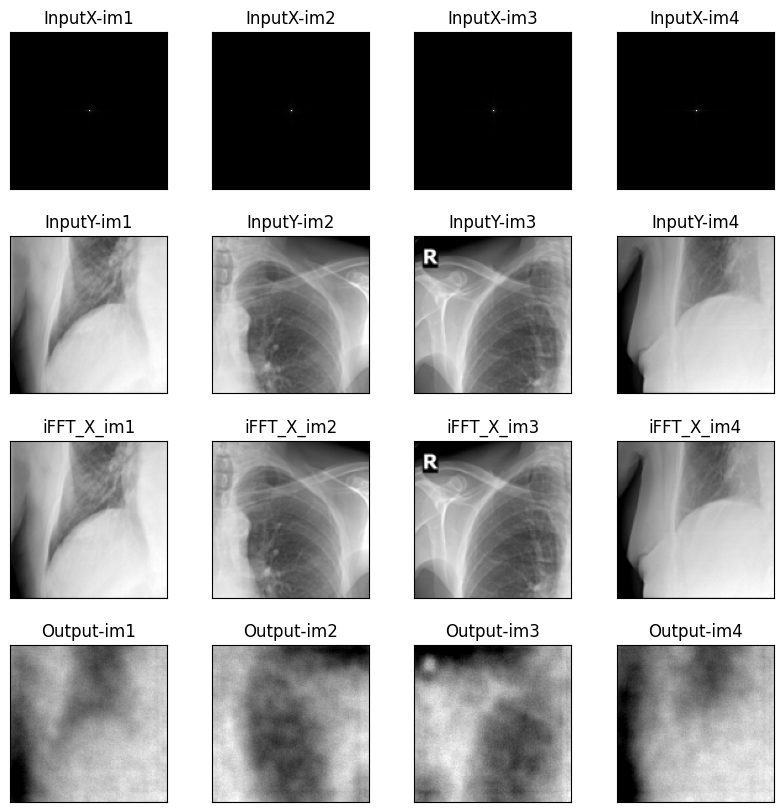

In [17]:
# Other part of your code remains the same ...
# Visualize the images, their reconstruction using iFFT and using trained model
# 4 images to visualize:
im1 = 0
im2 = 1
im3 = 2
im4 = 3

# iFFT back to image from corrupted frequency space
# Complex image from real and imaginary part
X_dev_compl = X_dev[:, :, :, 0] + X_dev[:, :, :, 1] * 1j

#iFFT
X_iFFT0 = np.fft.ifft2(X_dev_compl[im1, :, :])
X_iFFT1 = np.fft.ifft2(X_dev_compl[im2, :, :])
X_iFFT2 = np.fft.ifft2(X_dev_compl[im3, :, :])
X_iFFT3 = np.fft.ifft2(X_dev_compl[im4, :, :])

# Magnitude of complex image
X_iFFT_M1 = np.sqrt(np.power(X_iFFT0.real, 2)
                    + np.power(X_iFFT0.imag, 2))
X_iFFT_M2 = np.sqrt(np.power(X_iFFT1.real, 2)
                    + np.power(X_iFFT1.imag, 2))
X_iFFT_M3 = np.sqrt(np.power(X_iFFT2.real, 2)
                    + np.power(X_iFFT2.imag, 2))
X_iFFT_M4 = np.sqrt(np.power(X_iFFT3.real, 2)
                    + np.power(X_iFFT3.imag, 2))

# Display results
# Show X - input k-space
plt.figure(figsize = (10,10))
plt.subplot(441), plt.imshow(np.abs(X_dev_compl[im1, :, :]), cmap='gray')
plt.title('InputX-im1'), plt.xticks([]), plt.yticks([])
plt.subplot(442), plt.imshow(np.abs(X_dev_compl[im2, :, :]), cmap='gray')
plt.title('InputX-im2'), plt.xticks([]), plt.yticks([])
plt.subplot(443), plt.imshow(np.abs(X_dev_compl[im3, :, :]), cmap='gray')
plt.title('InputX-im3'), plt.xticks([]), plt.yticks([])
plt.subplot(444), plt.imshow(np.abs(X_dev_compl[im4, :, :]), cmap='gray')
plt.title('InputX-im4'), plt.xticks([]), plt.yticks([])

# Show Y - ground truth
plt.subplot(445), plt.imshow(Y_dev[im1, :, :], cmap='gray')
plt.title('InputY-im1'), plt.xticks([]), plt.yticks([])
plt.subplot(446), plt.imshow(Y_dev[im2, :, :], cmap='gray')
plt.title('InputY-im2'), plt.xticks([]), plt.yticks([])
plt.subplot(447), plt.imshow(Y_dev[im3, :, :], cmap='gray')
plt.title('InputY-im3'), plt.xticks([]), plt.yticks([])
plt.subplot(448), plt.imshow(Y_dev[im4, :, :], cmap='gray')
plt.title('InputY-im4'), plt.xticks([]), plt.yticks([])

# Show images reconstructed using iFFT
plt.subplot(449), plt.imshow(X_iFFT_M1, cmap='gray')
plt.title('iFFT_X_im1'), plt.xticks([]), plt.yticks([])
plt.subplot(4,4,10), plt.imshow(X_iFFT_M2, cmap='gray')
plt.title('iFFT_X_im2'), plt.xticks([]), plt.yticks([])
plt.subplot(4,4,11), plt.imshow(X_iFFT_M3, cmap='gray')
plt.title('iFFT_X_im3'), plt.xticks([]), plt.yticks([])
plt.subplot(4,4,12), plt.imshow(X_iFFT_M4, cmap='gray')
plt.title('iFFT_X_im4'), plt.xticks([]), plt.yticks([])

# Show images reconstructed using neural network
plt.subplot(4,4,13), plt.imshow(Y_recon[im1, :, :], cmap='gray')
plt.title('Output-im1'), plt.xticks([]), plt.yticks([])
plt.subplot(4,4,14), plt.imshow(Y_recon[im2, :, :], cmap='gray')
plt.title('Output-im2'), plt.xticks([]), plt.yticks([])
plt.subplot(4,4,15), plt.imshow(Y_recon[im3, :, :], cmap='gray')
plt.title('Output-im3'), plt.xticks([]), plt.yticks([])
plt.subplot(4,4,16), plt.imshow(Y_recon[im4, :, :], cmap='gray')
plt.title('Output-im4'), plt.xticks([]), plt.yticks([])
plt.subplots_adjust(hspace=0.3)
plt.show()

In [19]:
# Visualize the images, their reconstruction using iFFT and using trained model
# 4 images to visualize:
im1 = 15
im2 = 16
im3 = 17
im4 = 18

# iFFT back to image from corrupted frequency space
# Complex image from real and imaginary part
X_dev_compl = X_dev[:, :, :, 0] + X_dev[:, :, :, 1] * 1j

#iFFT
X_iFFT0 = np.fft.ifft2(X_dev_compl[im1, :, :])
X_iFFT1 = np.fft.ifft2(X_dev_compl[im2, :, :])
X_iFFT2 = np.fft.ifft2(X_dev_compl[im3, :, :])
X_iFFT3 = np.fft.ifft2(X_dev_compl[im4, :, :])

# Magnitude of complex image
X_iFFT_M1 = np.sqrt(np.power(X_iFFT0.real, 2)
                    + np.power(X_iFFT0.imag, 2))
X_iFFT_M2 = np.sqrt(np.power(X_iFFT1.real, 2)
                    + np.power(X_iFFT1.imag, 2))
X_iFFT_M3 = np.sqrt(np.power(X_iFFT2.real, 2)
                    + np.power(X_iFFT2.imag, 2))
X_iFFT_M4 = np.sqrt(np.power(X_iFFT3.real, 2)
                    + np.power(X_iFFT3.imag, 2))

# Display results
# Show X - input k-space
plt.figure(figsize = (10,10))
plt.subplot(441), plt.imshow(np.abs(X_dev_compl[im1, :, :]), cmap='gray')
plt.title('InputX-im1'), plt.xticks([]), plt.yticks([])
plt.subplot(442), plt.imshow(np.abs(X_dev_compl[im2, :, :]), cmap='gray')
plt.title('InputX-im2'), plt.xticks([]), plt.yticks([])
plt.subplot(443), plt.imshow(np.abs(X_dev_compl[im3, :, :]), cmap='gray')
plt.title('InputX-im3'), plt.xticks([]), plt.yticks([])
plt.subplot(444), plt.imshow(np.abs(X_dev_compl[im4, :, :]), cmap='gray')
plt.title('InputX-im4'), plt.xticks([]), plt.yticks([])

# Show Y - ground truth
plt.subplot(445), plt.imshow(Y_dev[im1, :, :], cmap='gray')
plt.title('InputY-im1'), plt.xticks([]), plt.yticks([])
plt.subplot(446), plt.imshow(Y_dev[im2, :, :], cmap='gray')
plt.title('InputY-im2'), plt.xticks([]), plt.yticks([])
plt.subplot(447), plt.imshow(Y_dev[im3, :, :], cmap='gray')
plt.title('InputY-im3'), plt.xticks([]), plt.yticks([])
plt.subplot(448), plt.imshow(Y_dev[im4, :, :], cmap='gray')
plt.title('InputY-im4'), plt.xticks([]), plt.yticks([])

# Show images reconstructed using iFFT
plt.subplot(449), plt.imshow(X_iFFT_M1, cmap='gray')
plt.title('iFFT_X_im1'), plt.xticks([]), plt.yticks([])
plt.subplot(4,4,10), plt.imshow(X_iFFT_M2, cmap='gray')
plt.title('iFFT_X_im2'), plt.xticks([]), plt.yticks([])
plt.subplot(4,4,11), plt.imshow(X_iFFT_M3, cmap='gray')
plt.title('iFFT_X_im3'), plt.xticks([]), plt.yticks([])
plt.subplot(4,4,12), plt.imshow(X_iFFT_M4, cmap='gray')
plt.title('iFFT_X_im4'), plt.xticks([]), plt.yticks([])

# Show images reconstructed using neural network
plt.subplot(4,4,13), plt.imshow(Y_recon[im1, :, :], cmap='gray')
plt.title('Output-im1'), plt.xticks([]), plt.yticks([])
plt.subplot(4,4,14), plt.imshow(Y_recon[im2, :, :], cmap='gray')
plt.title('Output-im2'), plt.xticks([]), plt.yticks([])
plt.subplot(4,4,15), plt.imshow(Y_recon[im3, :, :], cmap='gray')
plt.title('Output-im3'), plt.xticks([]), plt.yticks([])
plt.subplot(4,4,16), plt.imshow(Y_recon[im4, :, :], cmap='gray')
plt.title('Output-im4'), plt.xticks([]), plt.yticks([])
plt.subplots_adjust(hspace=0.3)
plt.show()

IndexError: ignored

pytorch code

---



In [4]:
def create_x(y, normalize=False):
    """
    Prepares frequency data from image data: applies to_freq_space,
    expands the dimensions from 3D to 4D, and normalizes if normalize=True
    :param y: input image
    :param normalize: if True - the frequency data will be normalized
    :return: frequency data 4D array of size (1, im_size1, im_size2, 2)
    """
    x = to_freq_space(y)  # FFT: (128, 128, 2)
    x = np.expand_dims(x, axis=0)  # (1, 128, 128, 2)
    if normalize:
        x = x - np.mean(x)

    return x


def to_freq_space(img):
    """ Performs FFT of an image
    :param img: input 2D image
    :return: Frequency-space data of the input image, third dimension (size: 2)
    contains real ans imaginary part
    """

    img_f = np.fft.fft2(img)  # FFT
    img_fshift = np.fft.fftshift(img_f)  # FFT shift
    img_real = img_fshift.real  # Real part: (im_size1, im_size2)
    img_imag = img_fshift.imag  # Imaginary part: (im_size1, im_size2)
    img_real_imag = np.dstack((img_real, img_imag))  # (im_size1, im_size2, 2)

    return img_real_imag



def load_x_ray_data(train_imgs_dir, img_file_start, img_file_stop):
  # Get a list of all the image file paths
  file_paths = glob.glob(f'{train_imgs_dir}/*.png')
  file_paths = file_paths[img_file_start:img_file_stop]

  # Create a dataset of the file paths
  dataset = tf.data.Dataset.from_tensor_slices(file_paths)

  # Function to load and preprocess each image
  def load_and_preprocess_image(path):
      # Read the image from disk
      image = tf.io.read_file(path)

      # Decode the image
      image = tf.image.decode_image(image, channels=1)

      # Convert the image to float values between 0 and 1
      image = tf.image.convert_image_dtype(image, tf.float32)

      return image

  # Apply the function to each image in the dataset
  dataset = dataset.map(load_and_preprocess_image)

  # Convert the dataset to a single tensor
  images = tf.stack(list(dataset))

  bigy = images.numpy()
  bigy = np.squeeze(bigy)

  print(f'bigy.shape = {bigy.shape}')

  # convert to k-space
  imgs, row, col = bigy.shape
  bigx = np.empty((imgs, row, col, 2))
  for i in range(imgs):
      bigx[i, :, :, :] = create_x(np.squeeze(bigy[i,:,:]), normalize=False)

      # print(f'processing image {i}/{range(imgs)}')

  # convert bigx from complex to abs values
  bigy = np.abs(bigy)

  return bigx, bigy

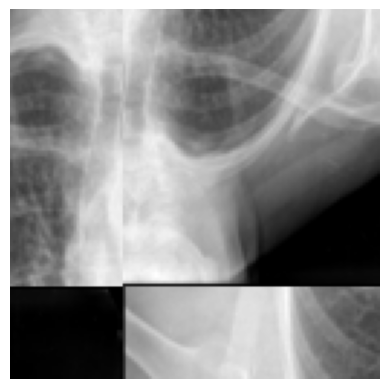

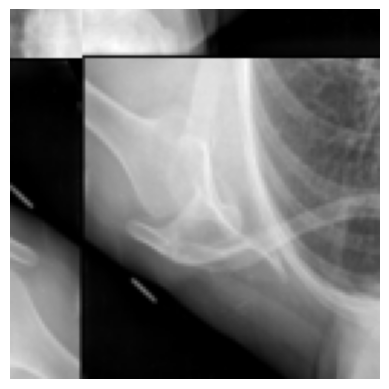

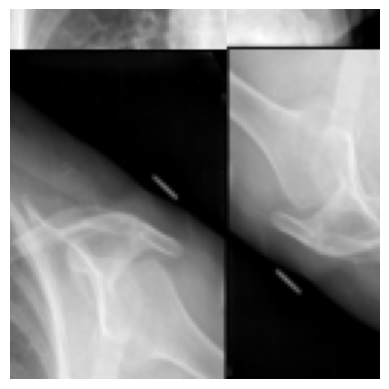

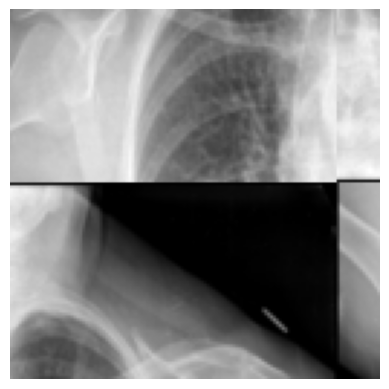

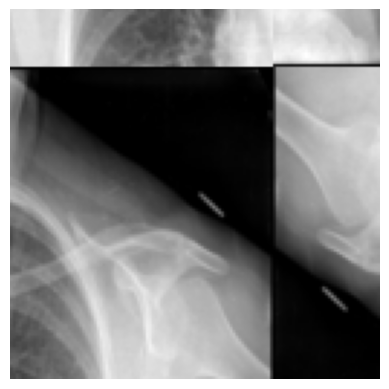

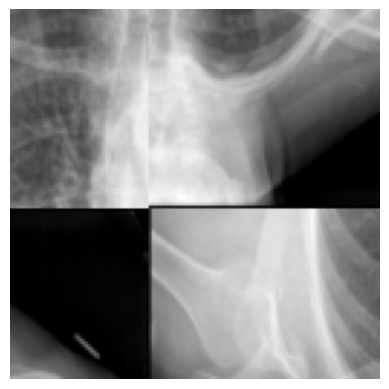

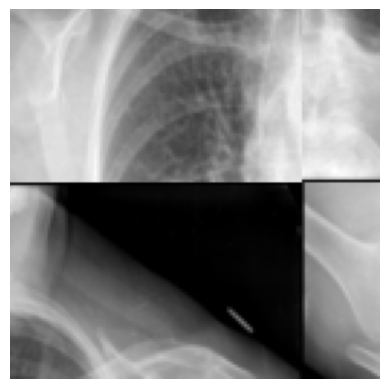

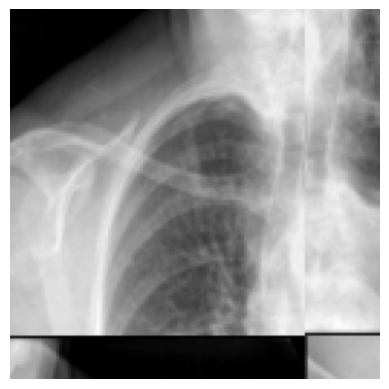

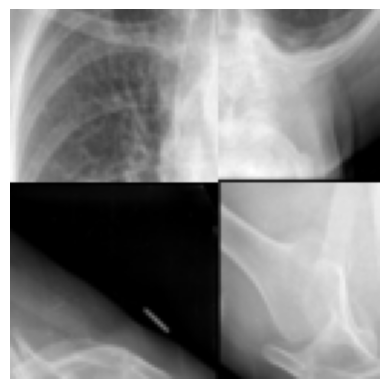

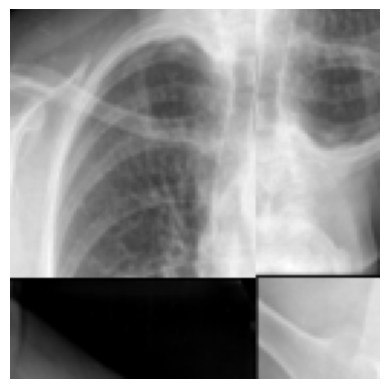

In [5]:
# import torch
# from torchvision.transforms import functional as F
# from torchvision.transforms import RandomCrop
# import PIL.Image as Image
# import numpy as np

class SymmetricTiling:
    def __init__(self, size=128, num_crops=10):
        self.size = size
        self.random_crop = RandomCrop(size)
        self.num_crops = num_crops

    def __call__(self, img):
        # Symmetrically tile the image
        top_bottom_flip = F.hflip(img)
        tiled_img = torch.cat((img, top_bottom_flip), dim=1)
        left_right_flip = F.vflip(tiled_img)
        tiled_img = torch.cat((tiled_img, left_right_flip), dim=2)

        # Random 128x128 cropping 10 times
        crops = []
        for _ in range(self.num_crops):
            crops.append(self.random_crop(tiled_img))

        return crops

# Assuming you're working with PIL Image, if not convert your image to PIL Image
img_path = "/content/drive/MyDrive/automap/img_tiles/file_0_tile_0.png"
img = Image.open(img_path)


# Convert PIL Image to tensor
img_tensor = F.to_tensor(img)

# Create the augmentor and apply
augmentor = SymmetricTiling()
augmented_tensors = augmentor(img_tensor)

for augmented_tensor in augmented_tensors:
  # Convert tensor back to PIL Image for visualization (if needed)
  augmented_img = F.to_pil_image(augmented_tensor)

  plt.imshow(augmented_img)
  plt.axis('off')  # Turn off the axis numbers
  plt.show()



In [6]:
input_img_dir = '/content/drive/MyDrive/automap/img_tiles'

def to_normalized_grayscale(tensor):
    # Convert tensor to grayscale by averaging the channels
    grayscale_tensor = tensor.mean(dim=0, keepdim=True)

    grayscale_tensor = grayscale_tensor.squeeze()

    # If the tensor values are between 0 and 255, divide by 255 to normalize
    if grayscale_tensor.max() > 1:
        grayscale_tensor = grayscale_tensor / 255.0

    # print(f'grayscale_tensor.shape = {grayscale_tensor.shape}')

    return grayscale_tensor


# Initialize the augmentor
augmentor = SymmetricTiling()

images = []
# Read and augment images from the directory
for img_name in os.listdir(input_img_dir):
    if img_name.endswith(".png"):
        img_path = os.path.join(input_img_dir, img_name)
        img = Image.open(img_path)

        # Convert PIL Image to tensor
        img_tensor = F.to_tensor(img)

        # Augment the image to get 10 random slices
        augmented_tensors = augmentor(img_tensor)

        # Apply the conversion to each tensor in augmented_tensors
        augmented_tensors = [to_normalized_grayscale(t) for t in augmented_tensors]
        augmented_tensors = torch.stack(augmented_tensors)
        # print(f'augmented_tensors shape = {augmented_tensors.shape}')

        images.append(augmented_tensors)


        # for augmented_tensor in augmented_tensors:
        #     # Convert tensor back to PIL Image
        #     augmented_img = F.to_pil_image(augmented_tensor)

        #     plt.imshow(augmented_img, cmap='gray')
        #     plt.axis('off')  # Turn off the axis numbers
        #     plt.show()

images = torch.cat(images, dim=0)
print(f'images shape ={images.shape}')
bigy = images.numpy()
bigy = np.squeeze(bigy)

print(f'bigy.shape = {bigy.shape}')

# convert to k-space
imgs, row, col = bigy.shape
bigx = np.empty((imgs, row, col, 2))
for i in range(imgs):
    bigx[i, :, :, :] = create_x(np.squeeze(bigy[i,:,:]), normalize=False)

    # print(f'processing image {i}/{range(imgs)}')

# convert bigx from complex to abs values
bigy = np.abs(bigy)

X_train = bigx
Y_train = bigy



images shape =torch.Size([5480, 128, 128])
bigy.shape = (5480, 128, 128)


In [7]:
# Define the AUTOMAP model
class AUTOMAP(nn.Module):
    def __init__(self, n_H0, n_W0):
        super(AUTOMAP, self).__init__()

        self.n_H0 = n_H0
        self.n_W0 = n_W0

        # Compute the output shape
        self.n_out = n_H0 * n_W0 * 2

        # Define layers
        self.fc1 = nn.Linear(n_H0 * n_W0 * 2, self.n_out)
        self.fc2 = nn.Linear(self.n_out, self.n_out)

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)

        # Deconvolutional layer
        self.deconv = nn.Conv2d(64, 1, kernel_size=7, padding=3)

        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()

    def forward(self, x):
        print(f'type x 1 = {type(x)}')
        print(f'x shape 1 = {x.shape}')
        x = x.view(x.shape[0], -1)  # Flatten
        print(f'type x 2 = {type(x)}')
        print(f'x shape 2 = {x.shape}')
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = x.view(x.shape[0], 1, self.n_H0, self.n_W0)  # Reshape
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.deconv(x))
        return x

def compute_cost(y_pred, y_true):
    """Computes cost (squared loss) between the prediction and the label image"""
    return torch.mean((y_pred - y_true) ** 2)

def train_model(model, X_train, Y_train, learning_rate=0.0001, num_epochs=100, minibatch_size=5):
    """Trains the model"""
    print(f'train model, X_train.shape={X_train.shape}')
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.9)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'device = {device}')

    for epoch in range(num_epochs):
        print(f'X_train.shape = {X_train.shape}')
        print(f'X_train.shape[0] = {X_train.shape[0]}')
        print(f'minibatch_size = {minibatch_size}')
        print(f'minibatch_size = {minibatch_size}')
        aligned_batch_count = (X_train.shape[0] // minibatch_size) * minibatch_size

        for i in range(0, aligned_batch_count, minibatch_size):
            x_batch_np = X_train[i:i+minibatch_size]
            y_batch_np = Y_train[i:i+minibatch_size]

            print(f'type(x_batch_np) 1 = {type(x_batch_np)}')

            # Convert to PyTorch tensor and ensure correct dtype
            x_batch = torch.tensor(x_batch_np, dtype=torch.float32).to(device)
            y_batch = torch.tensor(y_batch_np, dtype=torch.float32).to(device)

            x_batch_elem_size = x_batch.element_size()
            x_batch_numel = x_batch.numel()
            x_batch_mem_usage = x_batch_elem_size * x_batch_numel
            y_batch_elem_size = y_batch.element_size()
            y_batch_numel = y_batch.numel()
            y_batch_mem_usage = y_batch_elem_size * y_batch_numel

            print(f'x_batch_elem_size = {x_batch_elem_size}')
            print(f'x_batch_numel = {x_batch_numel}')
            print(f'x_batch_mem_usage = {x_batch_mem_usage}')
            print(f'y_batch_elem_size = {y_batch_elem_size}')
            print(f'y_batch_numel = {y_batch_numel}')
            print(f'y_batch_mem_usage = {y_batch_mem_usage}')


            print(f'type(x_batch) 2 = {type(x_batch)}')
            print(f'x_batch shape = {x_batch.shape}')

            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = compute_cost(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            if i % 100 == 0:
                print(f"Epoch: {epoch}, Iteration: {i}, Loss: {loss.item()}")

    return model

# Converting the data to PyTorch tensors might look something like:
# X_train = torch.tensor(X_train_np, dtype=torch.float32)
# Y_train = torch.tensor(Y_train_np, dtype=torch.float32)


In [8]:
print(f'gpu memory_allocated = {torch.cuda.memory_allocated()}')  # Returns the current GPU memory usage by tensors in bytes
print(f'gpu cuda memory reserved = {torch.cuda.memory_reserved()}')   # Returns the current GPU memory managed by the caching allocator in bytes
torch.cuda.empty_cache()
gc.collect()
print(f'gpu memory_allocated = {torch.cuda.memory_allocated()}')  # Returns the current GPU memory usage by tensors in bytes
print(f'gpu cuda memory reserved = {torch.cuda.memory_reserved()}')   # Returns the current GPU memory managed by the caching allocator in bytes


gpu memory_allocated = 0
gpu cuda memory reserved = 0
gpu memory_allocated = 0
gpu cuda memory reserved = 0


In [23]:
del model


NameError: ignored

In [22]:

gc.collect()

0

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [10]:
model = AUTOMAP(X_train.shape[1], X_train.shape[2])

print(f'Total trainable parameters [Mbyes]: {count_parameters(model) * 4 / 1e6}')

print(model.to('cpu'))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device = {device}')
model.to(device)



Total trainable parameters [Mbyes]: 8590.625796
AUTOMAP(
  (fc1): Linear(in_features=32768, out_features=32768, bias=True)
  (fc2): Linear(in_features=32768, out_features=32768, bias=True)
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (deconv): Conv2d(64, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (tanh): Tanh()
  (relu): ReLU()
)
device = cuda


AUTOMAP(
  (fc1): Linear(in_features=32768, out_features=32768, bias=True)
  (fc2): Linear(in_features=32768, out_features=32768, bias=True)
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (deconv): Conv2d(64, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (tanh): Tanh()
  (relu): ReLU()
)

In [12]:

model = train_model(model, X_train=X_train, Y_train=Y_train, num_epochs=20)

train model, X_train.shape=(5480, 128, 128, 2)
device = cuda
X_train.shape = (5480, 128, 128, 2)
X_train.shape[0] = 5480
minibatch_size = 5
minibatch_size = 5
type(x_batch_np) 1 = <class 'numpy.ndarray'>
x_batch_elem_size = 4
x_batch_numel = 163840
x_batch_mem_usage = 655360
y_batch_elem_size = 4
y_batch_numel = 81920
y_batch_mem_usage = 327680
type(x_batch) 2 = <class 'torch.Tensor'>
x_batch shape = torch.Size([5, 128, 128, 2])
type x 1 = <class 'torch.Tensor'>
x shape 1 = torch.Size([5, 128, 128, 2])
type x 2 = <class 'torch.Tensor'>
x shape 2 = torch.Size([5, 32768])


NameError: ignored